In [1]:
import datetime
from collections import defaultdict
import json
import os
import matplotlib.pyplot as plt
import pylab
import re
import numpy as np

In [2]:
OUTPUT_PATH = "/lfs/1/keshav2/benchmarking/benchmark_output/runs/openai_runtimes_over_time"

In [3]:
def get_per_instance_runtimes(per_instance_metrics):
    runtimes = []
    for values in per_instance_metrics.values():
        for metric in values:
            if metric["name"]["name"] == "inference_runtime":
                runtimes.append(metric["values"][0])
    return runtimes

In [4]:
data = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
metric_dirs = os.listdir(OUTPUT_PATH)
pattern = (
    f"synthetic_efficiency:tokenizer=huggingface_gpt2,"
    f"num_input_tokens=(\d+),"
    f"num_output_tokens=(\d+),"
    f"random=(.*),"
    f"model=(.*)"
)
for metric_dir in metric_dirs:
    match = re.match(pattern, metric_dir)
    if match is None:
        continue
    num_input_tokens = int(match.group(1))
    num_output_tokens = int(match.group(2))
    random = match.group(3)
    model = match.group(4).replace("_", "/")
    month, day, year = random.split("_")
    date = datetime.datetime(year=int(year), month=int(month), day=int(day))
    path = os.path.join(OUTPUT_PATH, metric_dir, "per_instance_stats.json")
    if os.path.exists(path):
        with open(path, "r") as f:
            per_instance_metrics = json.load(f)
            per_instance_runtimes = get_per_instance_runtimes(per_instance_metrics)
    else:
        per_instance_runtimes = [None]
    data[model][num_input_tokens][num_output_tokens][date] = per_instance_runtimes

/lfs/1/keshav2/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


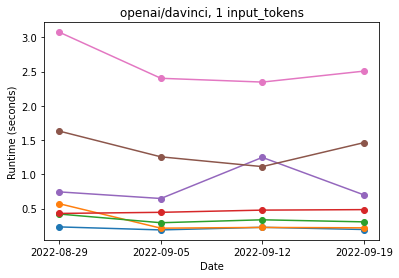

<Figure size 1080x72 with 0 Axes>

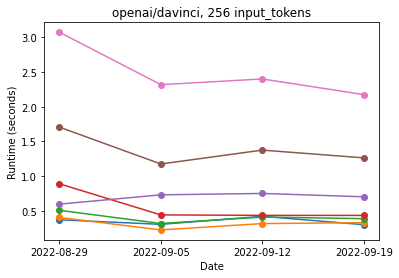

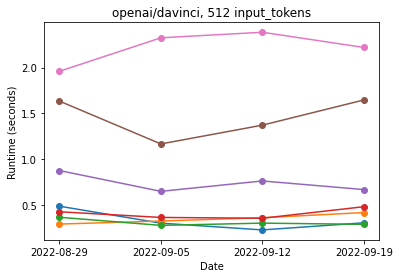

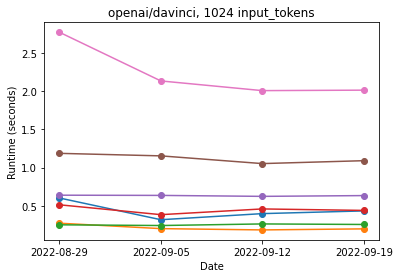

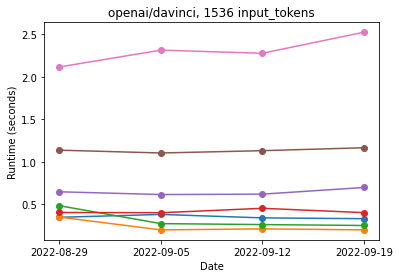

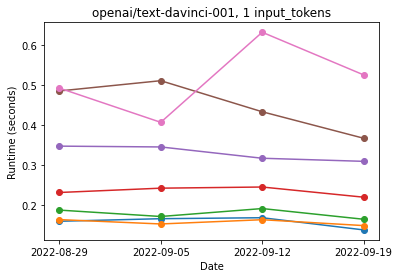

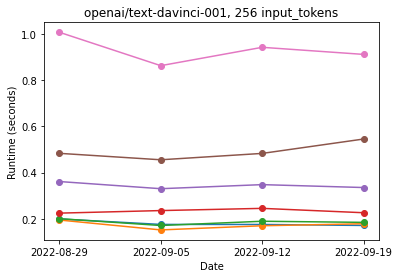

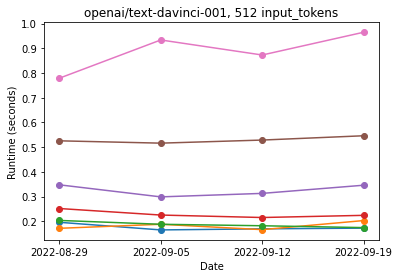

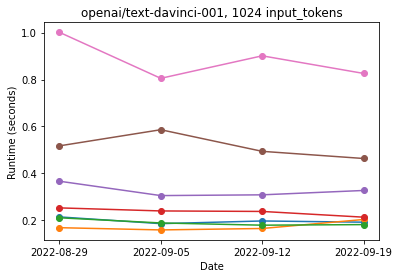

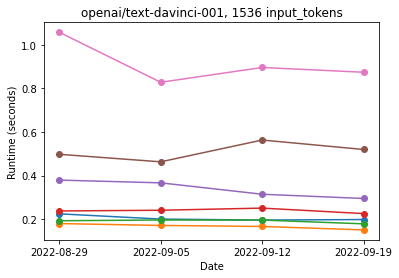

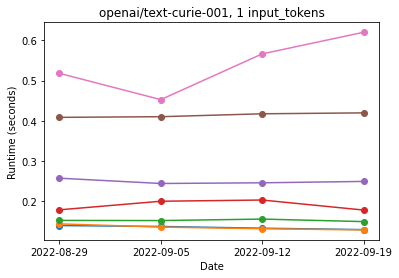

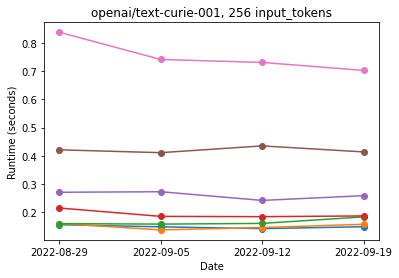

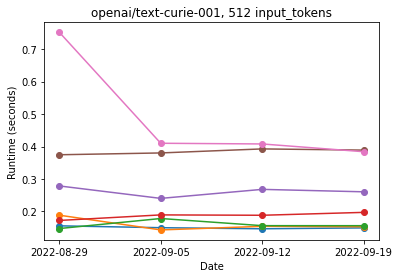

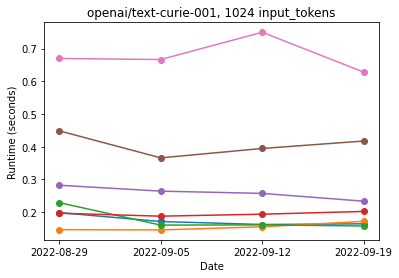

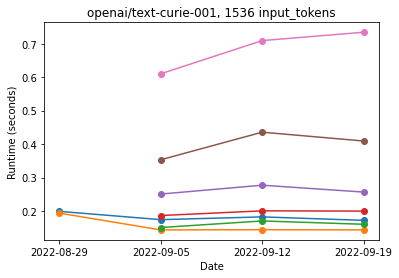

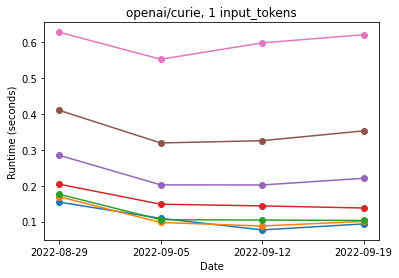

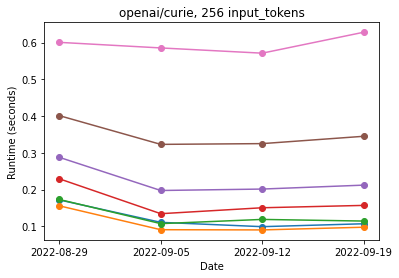

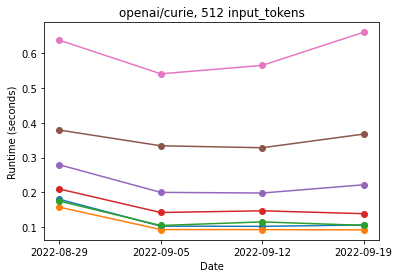

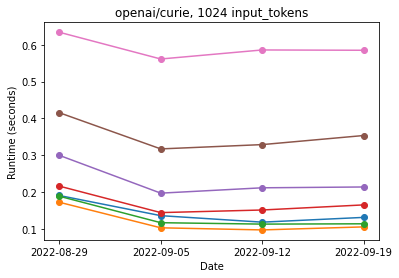

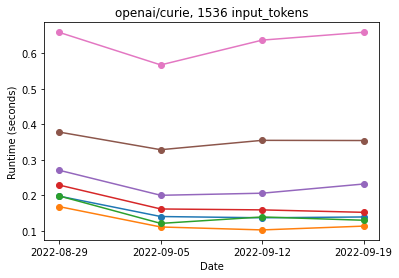

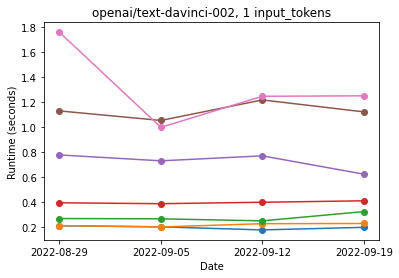

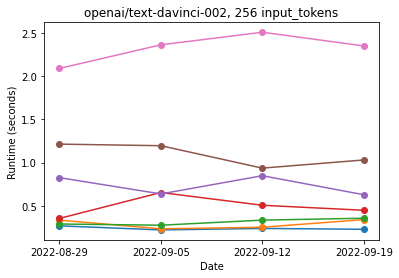

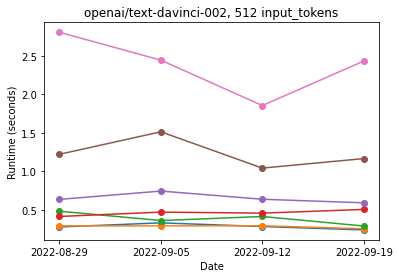

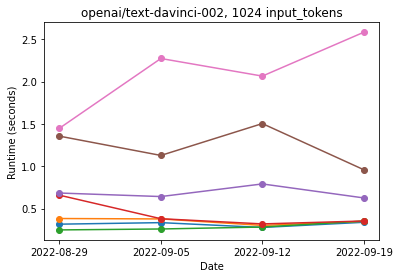

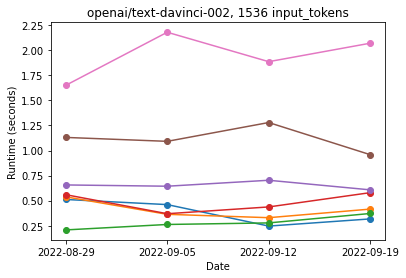

In [5]:
legend = True
for model in data:
    for num_input_tokens in sorted(data[model].keys()):
        fig = pylab.figure()
        if legend:
            figlegend = pylab.figure(figsize=(15, 1))
        ax = fig.add_subplot(111)
        lines = []
        labels = []
        for num_output_tokens in sorted(data[model][num_input_tokens].keys()):
            dates = sorted(data[model][num_input_tokens][num_output_tokens].keys())
            runtimes = [
                np.min(data[model][num_input_tokens][num_output_tokens][date])
                for date in dates
            ]
            label = f"{num_output_tokens} output tokens"
            lines.append(
                ax.plot(list(range(len(dates))), runtimes, label=label, marker="o")[0]
            )
            labels.append(label)
            ax.set_xticks(list(range(len(dates))))
            ax.set_xticklabels([str(date.date()) for date in dates])
            ax.set_xlabel("Date")
            ax.set_ylabel("Runtime (seconds)")

        if legend:
            figlegend.legend(
                lines,
                labels,
                loc="center",
                frameon=False,
                ncol=1,
                columnspacing=None,
                labelspacing=None,
            )
            legend = False

        ax.set_title(f"{model}, {num_input_tokens} input_tokens")

        plt.savefig(
            (f"/lfs/1/keshav2/benchmarking_efficiency/figures/runtimes_over_time/"
             f"model={model.replace('/', '_')},num_prompt_tokens={num_input_tokens}.pdf"),
            bbox_inches="tight",
        )